In [ ]:
# Imports
library(Seurat)
library(dplyr)
library(celldex)
library(ggplot2)
library(SingleR)
library(scater)
library(SingleCellExperiment)
library(SeuratDisk)
library(gridExtra)
library(zellkonverter)
library(clustree)
library(scDblFinder)

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Warning message:
"package 'dplyr' was built under R version 4.4.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


Th

In [16]:
# Function to use ScDblFinder to find doublets
remove_seurat_doublets <- function(seurat_object) {
    # To be able to use ScDBIFinder, we need to convert it to SCE
    sce_object <- as.SingleCellExperiment(seurat_object)
    
    # Run scDblFinder function
    sce_object <- scDblFinder(sce_object)

    # View table
    table(sce_object$scDblFinder.class)

    # as.Seurat needs logcounts but we dont want to calculate log counts, to trick we assume sce logcounts = counts
    logcounts(sce_object) <- assay(sce_object, "counts")

    # Convert SCE object back to Seurat
    seurat_object <- as.Seurat(sce_object)
    seurat_object <- subset(seurat_object, subset = scDblFinder.class == "singlet")
    seurat_object[["RNA"]] <- as(seurat_object[["RNA"]], "Assay5")
    return(seurat_object)
}

In [ ]:
# Set wd
setwd("../../../Data/Menno de Winther")
list.files()
getwd()

# Read in data
P3 <- Read10X(data.dir = "P3")
P5 <- Read10X(data.dir = "P5")
P7 <- Read10X(data.dir = "P7")

# Create Seurat objects
P3 <- CreateSeuratObject(P3, project="Depuydt et al. (2020), P3")
P5 <- CreateSeuratObject(P5, project="Depuydt et al. (2020), P5")
P7 <- CreateSeuratObject(P7, project="Depuydt et al. (2020), P7")

# To add reproducability in the future, consider adding BPARAM = bp, where bp = Multicore(n, seed) (Note: For the raw files the remove_seurat_doublets has not happened)
P3 <- remove_seurat_doublets(P3)
P5 <- remove_seurat_doublets(P5)
P7 <- remove_seurat_doublets(P7)

# Merge the Seurat objects
data <- merge(P3, y=list(P5, P7),
                    add.cell.ids = c("P3", "P5", "P7"),
                    project="All plaques merged")

# Merge layers
data[["RNA"]] <- JoinLayers(data[["RNA"]])

# Export R object for all mice integration
data[["Species"]] <- "Human"

#saveRDS(data, file = "Menno_raw.rds")


[1] "3 Human plaques 10X matrixes.zip" "menno_integrated.rds"            
[3] "Menno_myeloid_annotated.rds"      "Menno_myeloid_data.rds"          
[5] "P3"                               "P5"                              
[7] "P7"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Menno de Winther"

In [4]:
unique(data$orig.ident)

[1] "Depuydt et al. (2020), P3" "Depuydt et al. (2020), P5"
[3] "Depuydt et al. (2020), P7"

In [ ]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:significant_pcs, verbose=FALSE)
    
    # Integrate CCA
    data <- IntegrateLayers(object = data, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca", k.weight = k.weights)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", verbose=FALSE)

    return(data)
}

data <- pre_process(sc.data, pattern= "MT", percents.mt = 10)

Splitting 'counts', 'data' layers. Not splitting . If you would like to split other layers, set in `layers` argument.

Normalizing layer: counts.P3

Normalizing layer: counts.P5

Normalizing layer: counts.P7

Finding variable features for layer counts.P3

Finding variable features for layer counts.P5

Finding variable features for layer counts.P7

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4454 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6046 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8503
Number of edges: 333329

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8914
Number of communities: 16
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8503
Number of edges: 333329

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8802
Number of communities: 17
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8503
Number of edges: 333329

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8709
Number of communities: 18
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8503
Number of edges: 333329

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8625
Number of communities: 18
Elapsed time: 0 seconds
Modularity Optim

In [25]:
saveRDS(data, file = "menno_integrated.rds")

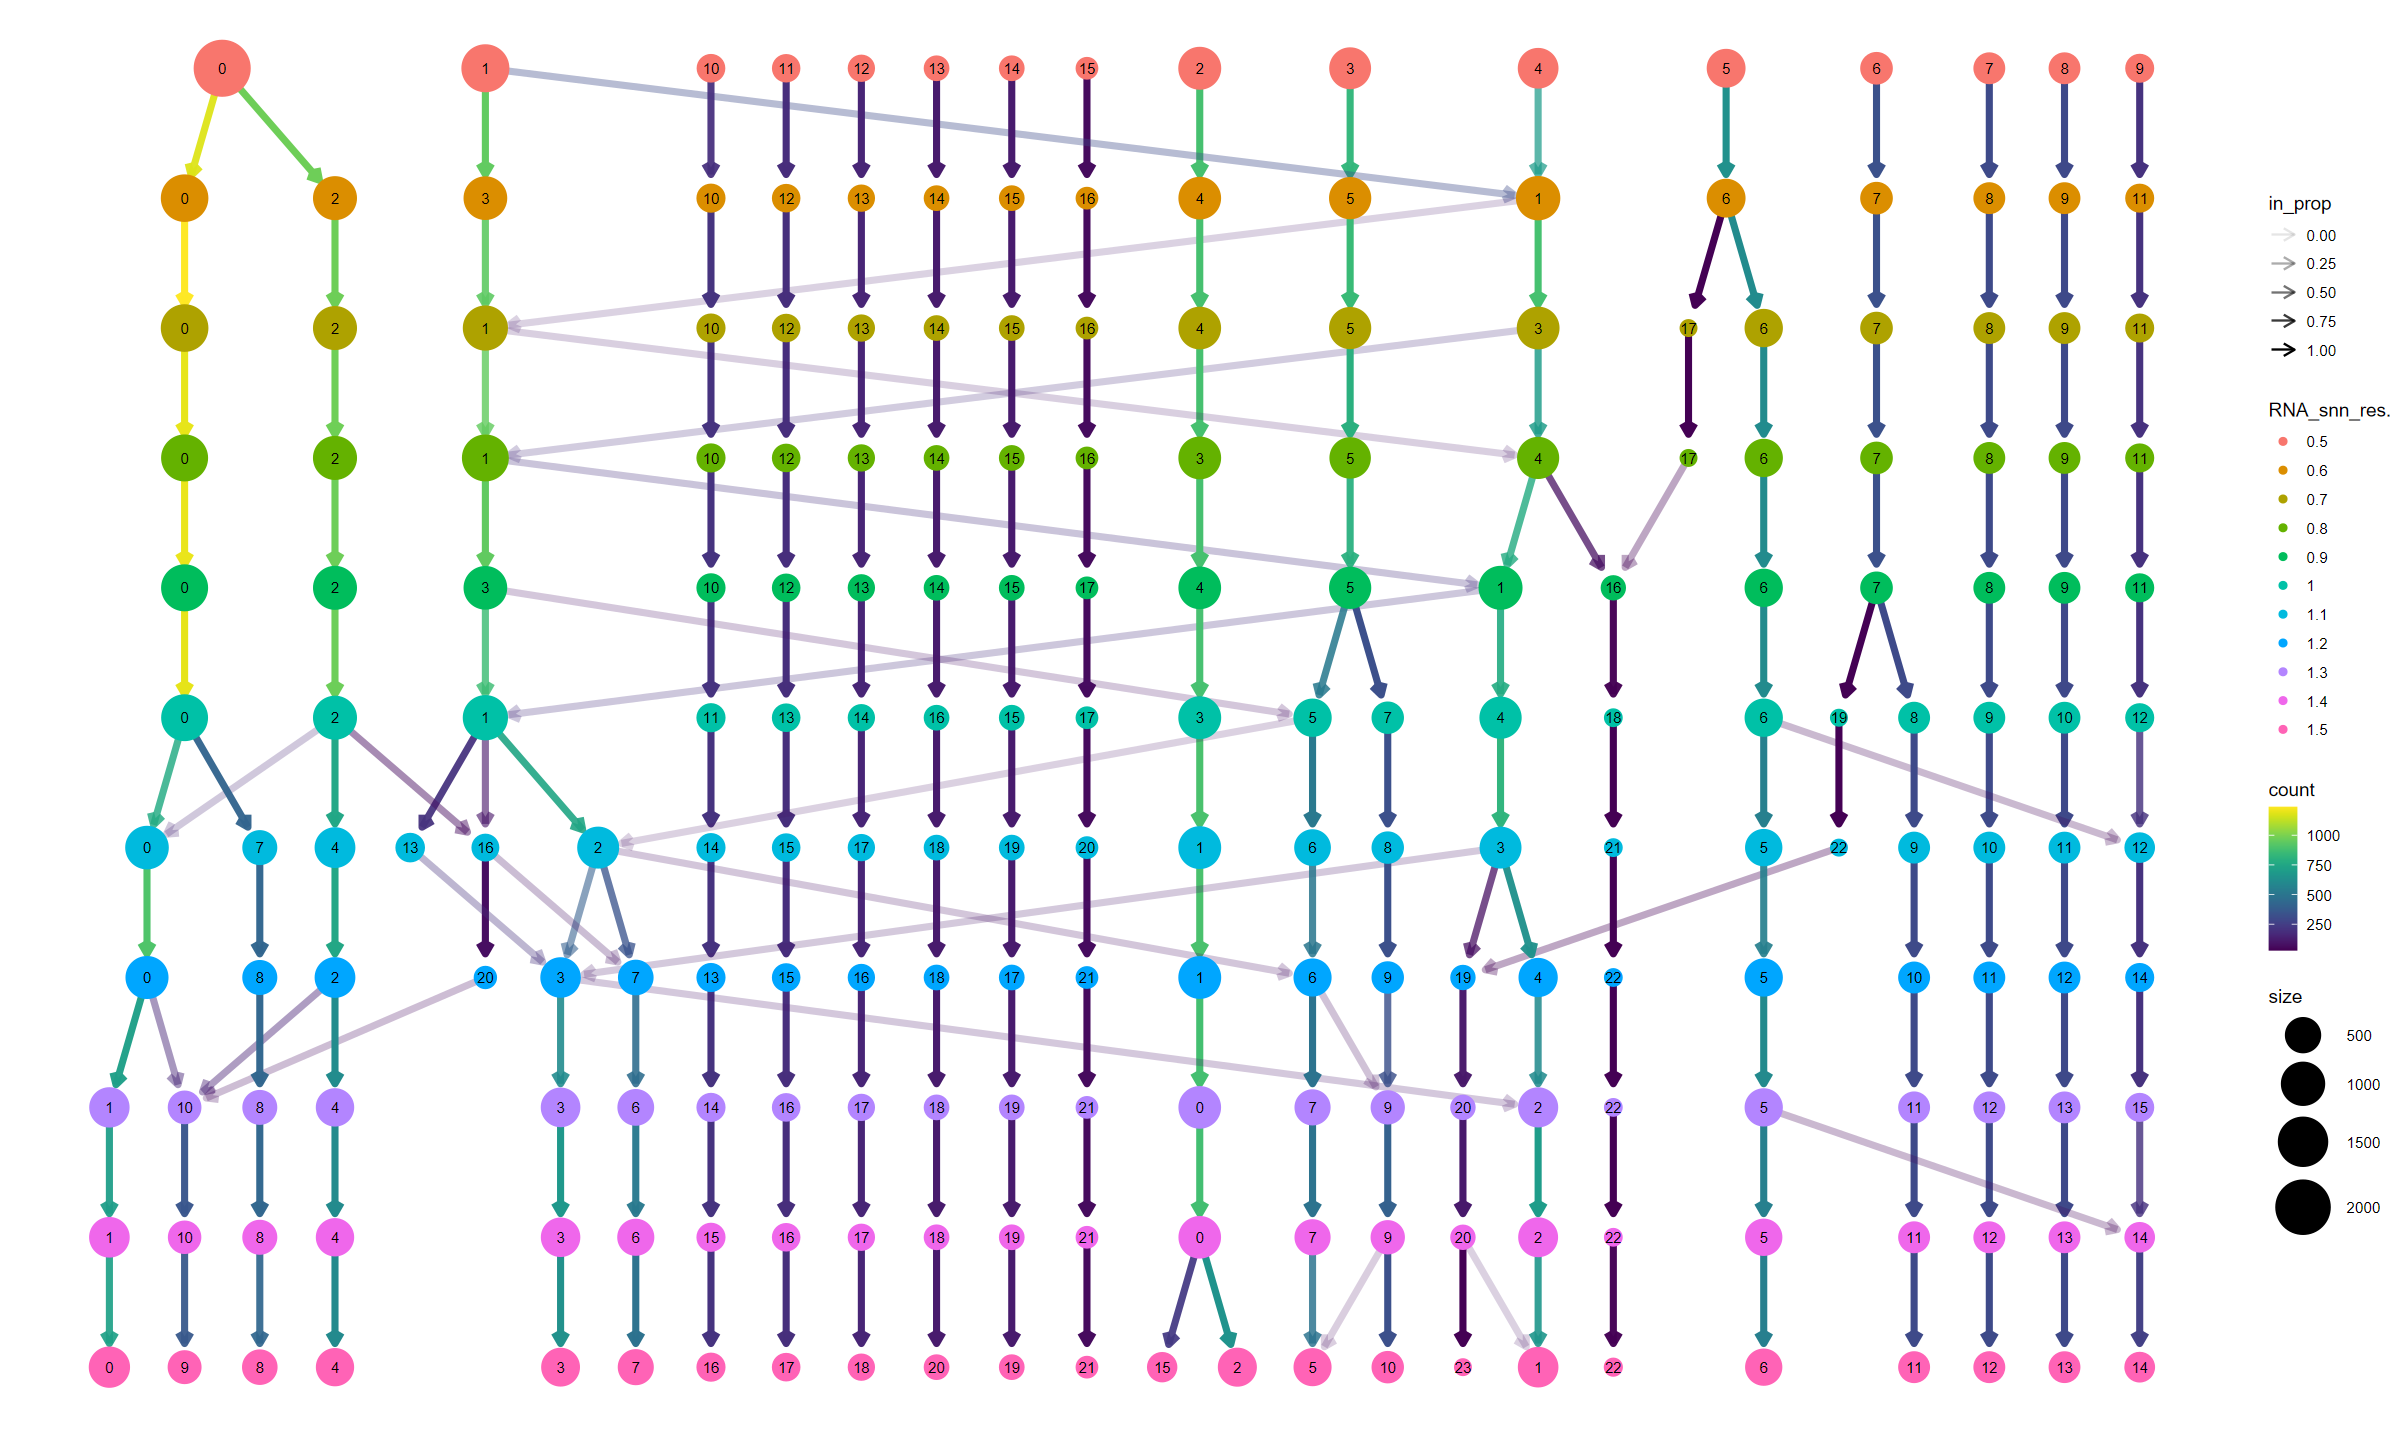

In [26]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

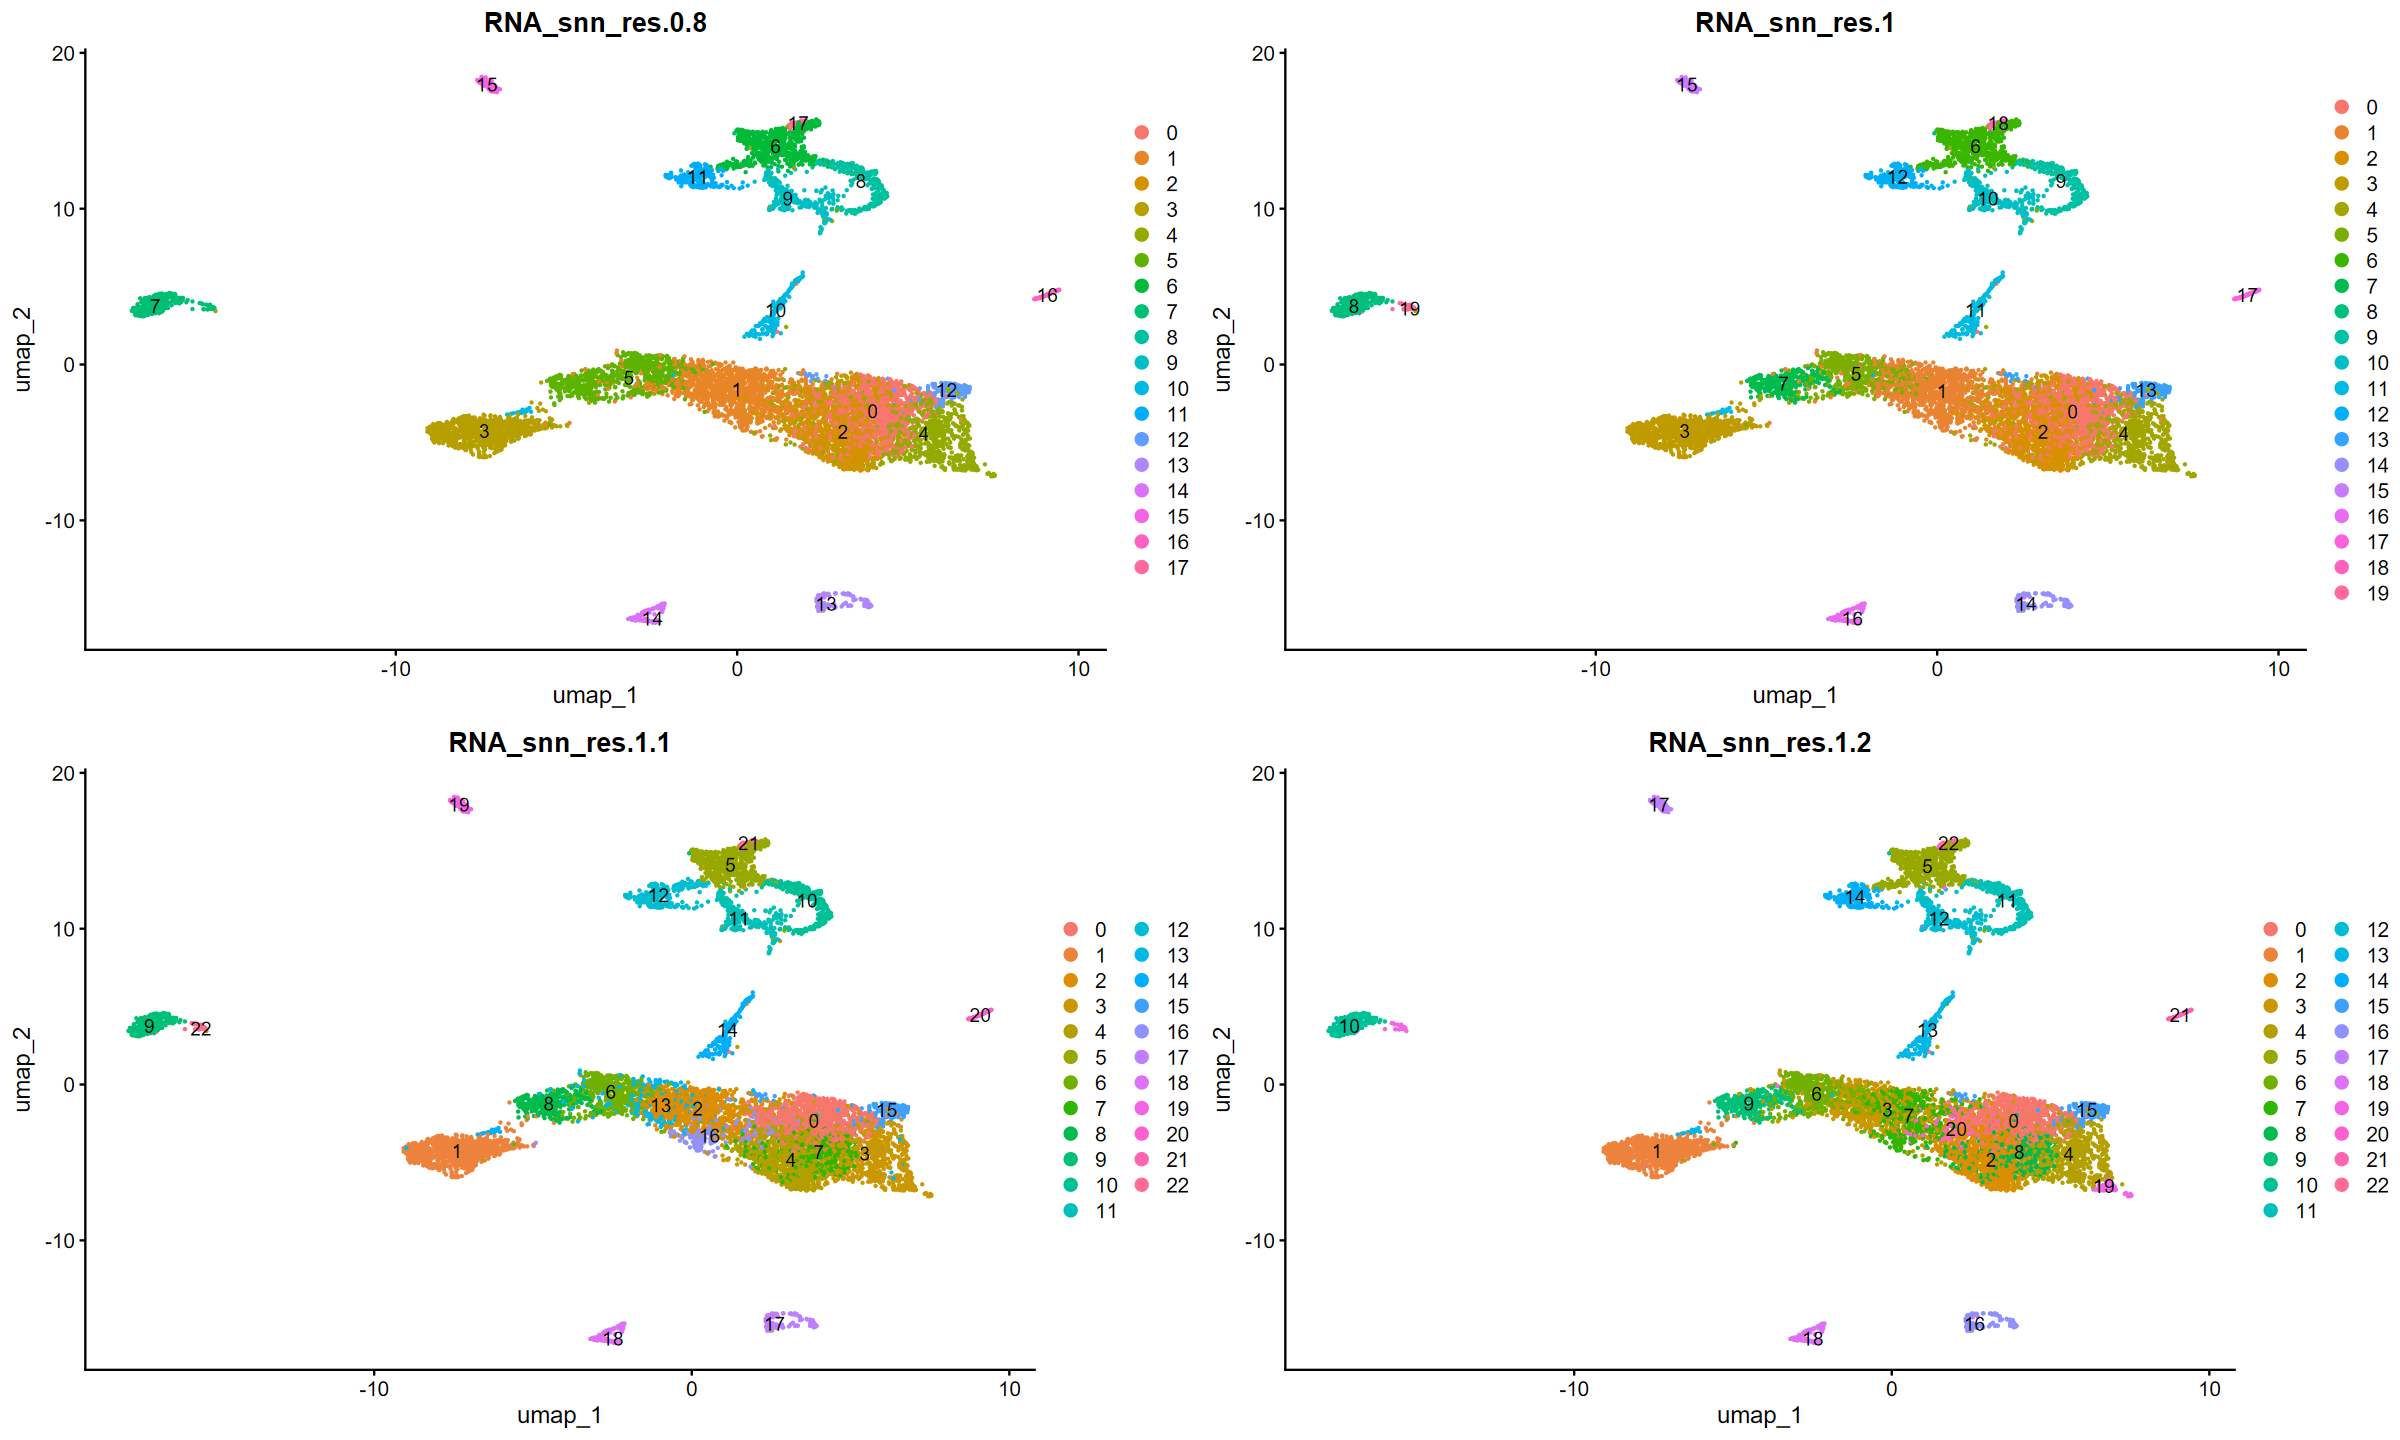

In [30]:
# Get DimPlots of different resolutions
res_1 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.0.8", label = T)
res_2 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1", label = T)
res_3 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1.1", label = T)
res_4 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1.2", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

In [31]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.0.8`

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Adipocytes,0,0,0,0,0,0,0,0,0,0,0,0,0,20,1,0,0,0
Astrocytes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
B-cells,0,0,0,0,0,0,0,311,0,0,1,0,0,0,1,85,0,0
CD4+ T-cells,382,2,524,0,223,0,0,2,1,0,17,0,99,1,4,0,0,0
CD8+ T-cells,820,1158,454,7,562,383,0,7,9,4,96,0,87,4,4,3,0,0
Chondrocytes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0
DC,0,0,0,0,0,0,0,0,0,0,1,19,0,0,0,0,25,0
Endothelial cells,0,0,0,0,2,0,0,0,0,0,1,0,0,124,0,0,0,0
Eosinophils,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0
Erythrocytes,0,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0


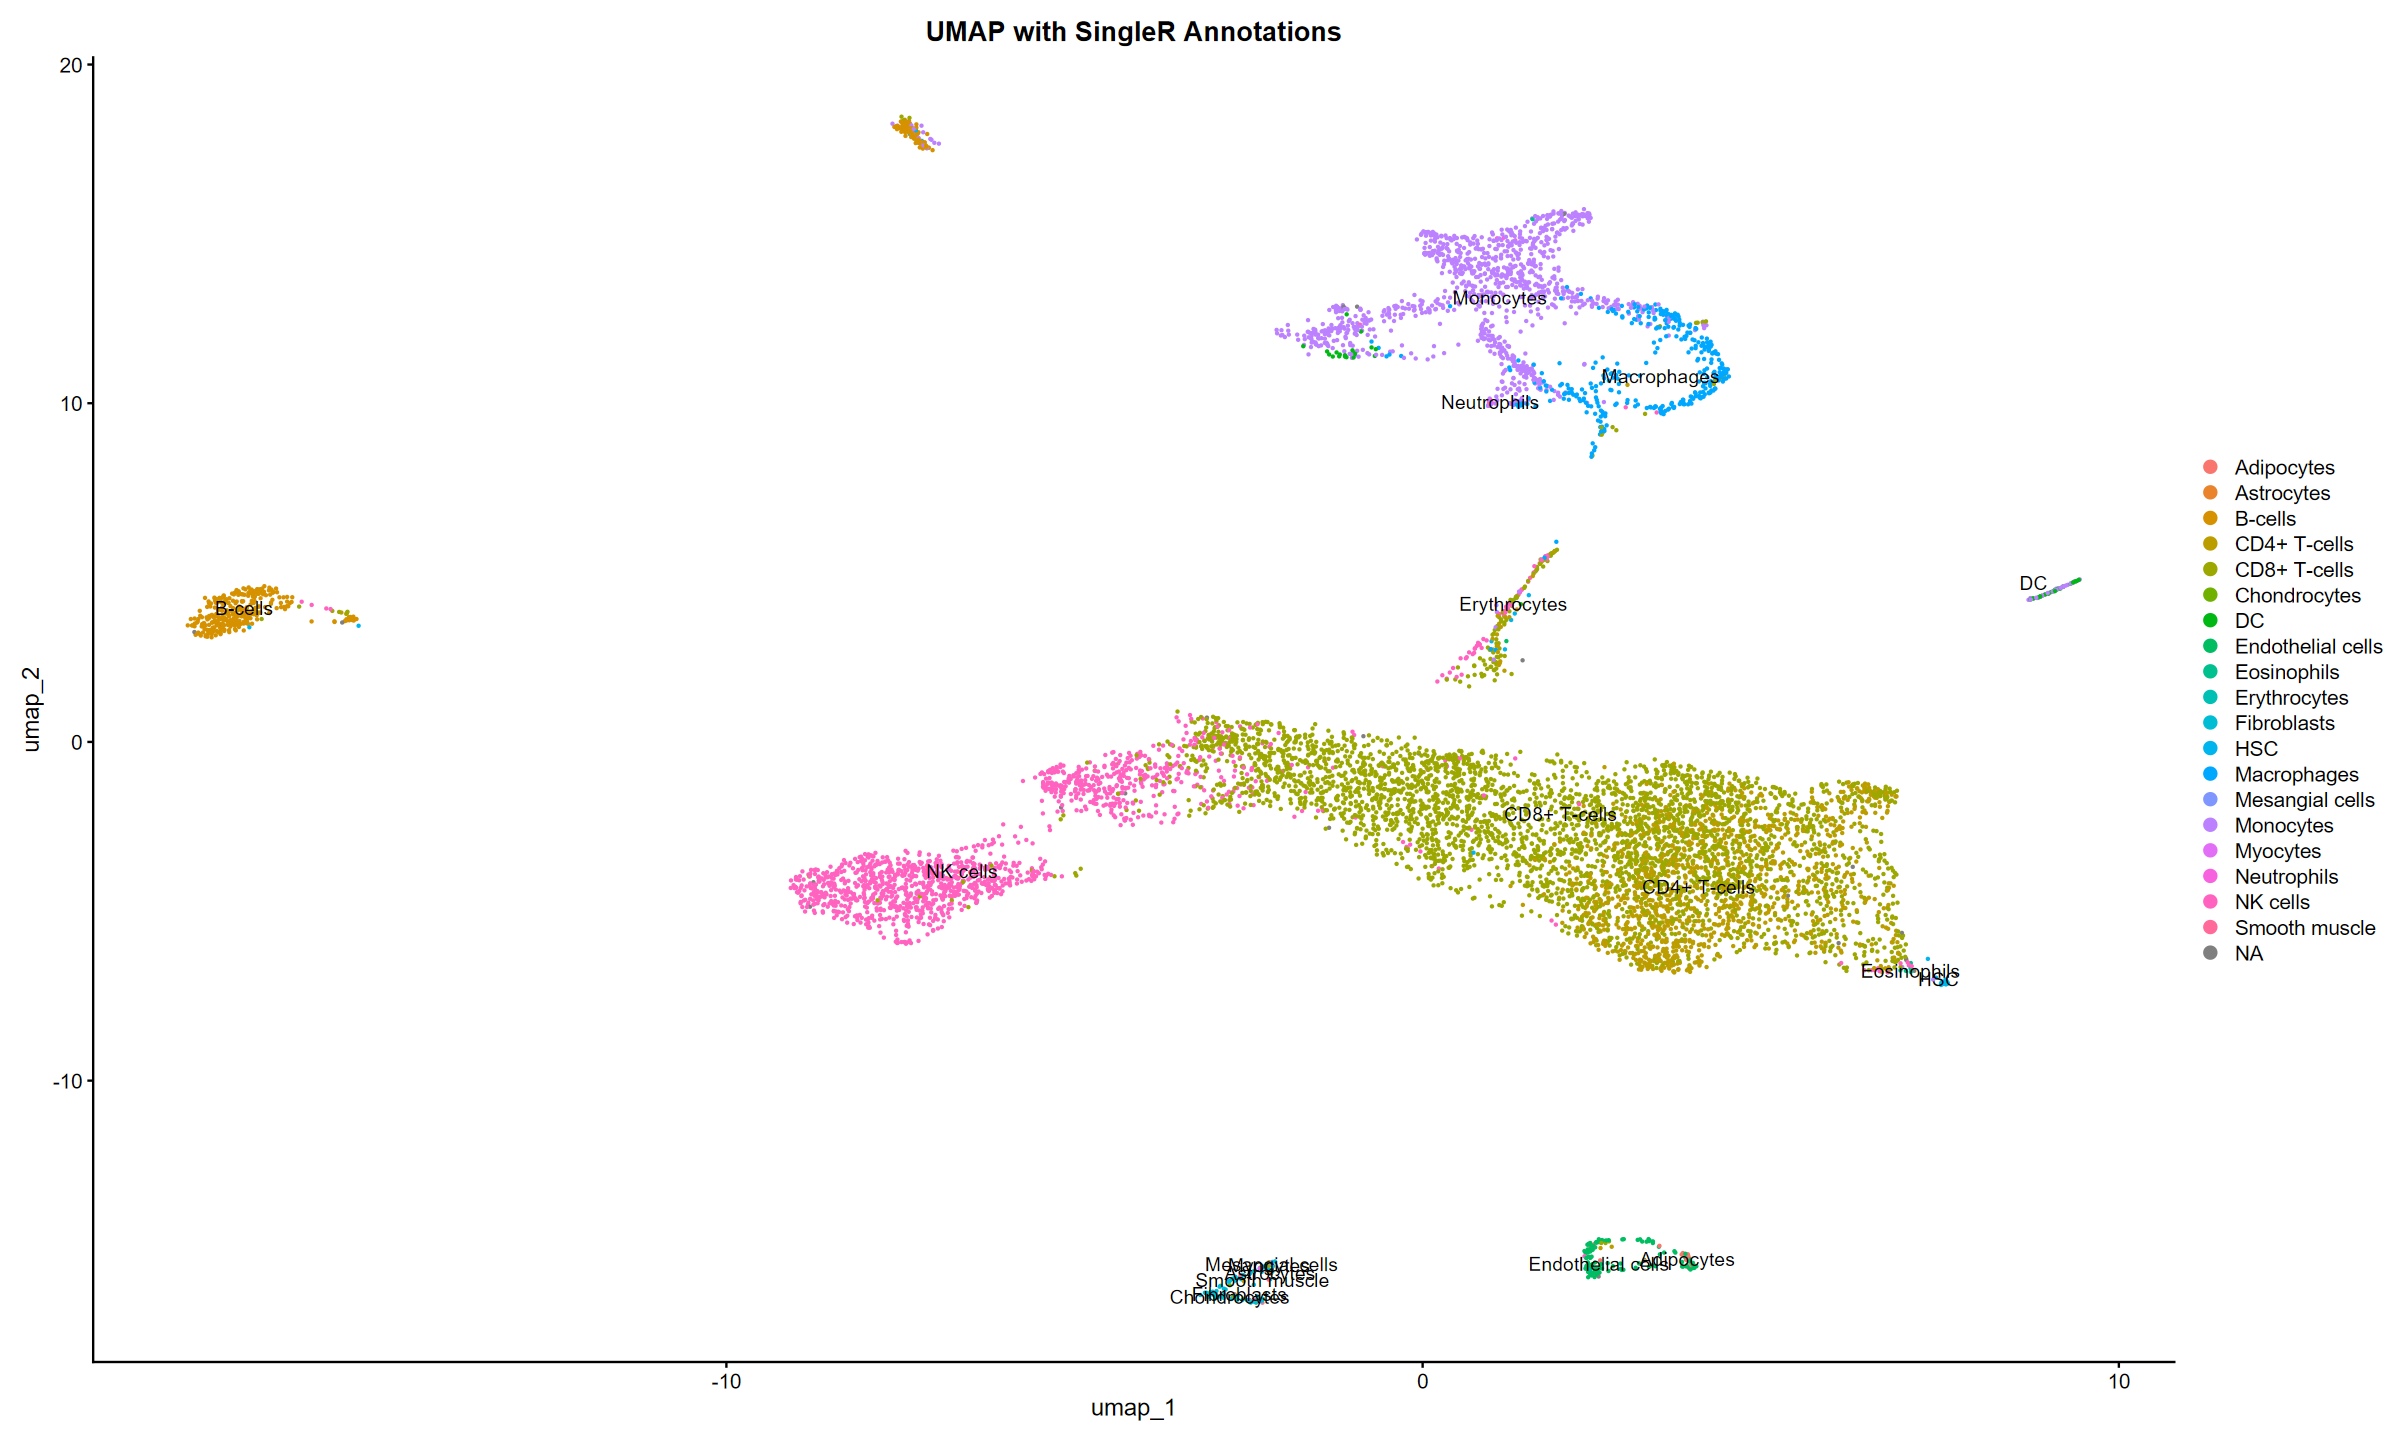

In [32]:
# Annotation code block

# Get reference atlas
hpca.se <- celldex::BlueprintEncodeData()
data.sce <- as.SingleCellExperiment(data)

# Predict
pred.hpca <- SingleR(test = data.sce, ref = hpca.se, assay.type.test=1,
    labels = hpca.se$label.main)

# View annotations
cluster_table <- cbind(table(pred.hpca$pruned.labels, data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.hpca$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

In [34]:
# Function to get the a specific cell type
get_macrophages <- function(data, table, cell_type = "Macrophages") {

    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which(t(cluster_table[cell_type, ] / colSums(cluster_table) * 100) > 5) - 1
    
    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% clusters)

    # And then only select the macrophages
    data <- subset(data, subset = SingleR_Labels == cell_type)

    return(data)
}

# Get myeloid cells
macrophages <- get_macrophages(data, cluster_table)
monocytes <- get_macrophages(data, cluster_table, cell_type = "Monocytes")
dendritic_cells <- get_macrophages(data, cluster_table, cell_type = "DC")


# Merge the Seurat objects
myeloid_cells <- merge(macrophages, y=c(monocytes, dendritic_cells))

# Merge layers
myeloid_cells[["RNA"]] <- JoinLayers(myeloid_cells[["RNA"]])

Warning message:
"Removing 4 cells missing data for vars requested"
Warning message:
"Removing 3 cells missing data for vars requested"


In [38]:
ncol(myeloid_cells)

[1] 1471

In [40]:
# To reintegrate, there needs to be a new Seurat Object created
myeloid_data <- CreateSeuratObject(
    counts = myeloid_cells@assays$RNA$counts,
    meta.data = myeloid_cells@meta.data)

In [ ]:
# Reprocess the subset
myeloid_data <- pre_process(myeloid_data, resolutions = seq(0.3, 1.3, by=0.1)) #, k.weights = 58)

Normalizing layer: counts.P3

Normalizing layer: counts.P5

Normalizing layer: counts.P7

Finding variable features for layer counts.P3

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -1.7959"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.30103"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  2.6986e-15"
Finding variable features for layer counts.P5

Finding variable features for layer counts.P7

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 604 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 609 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1696 anchors

Merging dataset 1 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1353
Number of edges: 44220

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8833
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1353
Number of edges: 44220

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8626
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1353
Number of edges: 44220

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8457
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1353
Number of edges: 44220

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8318
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer v

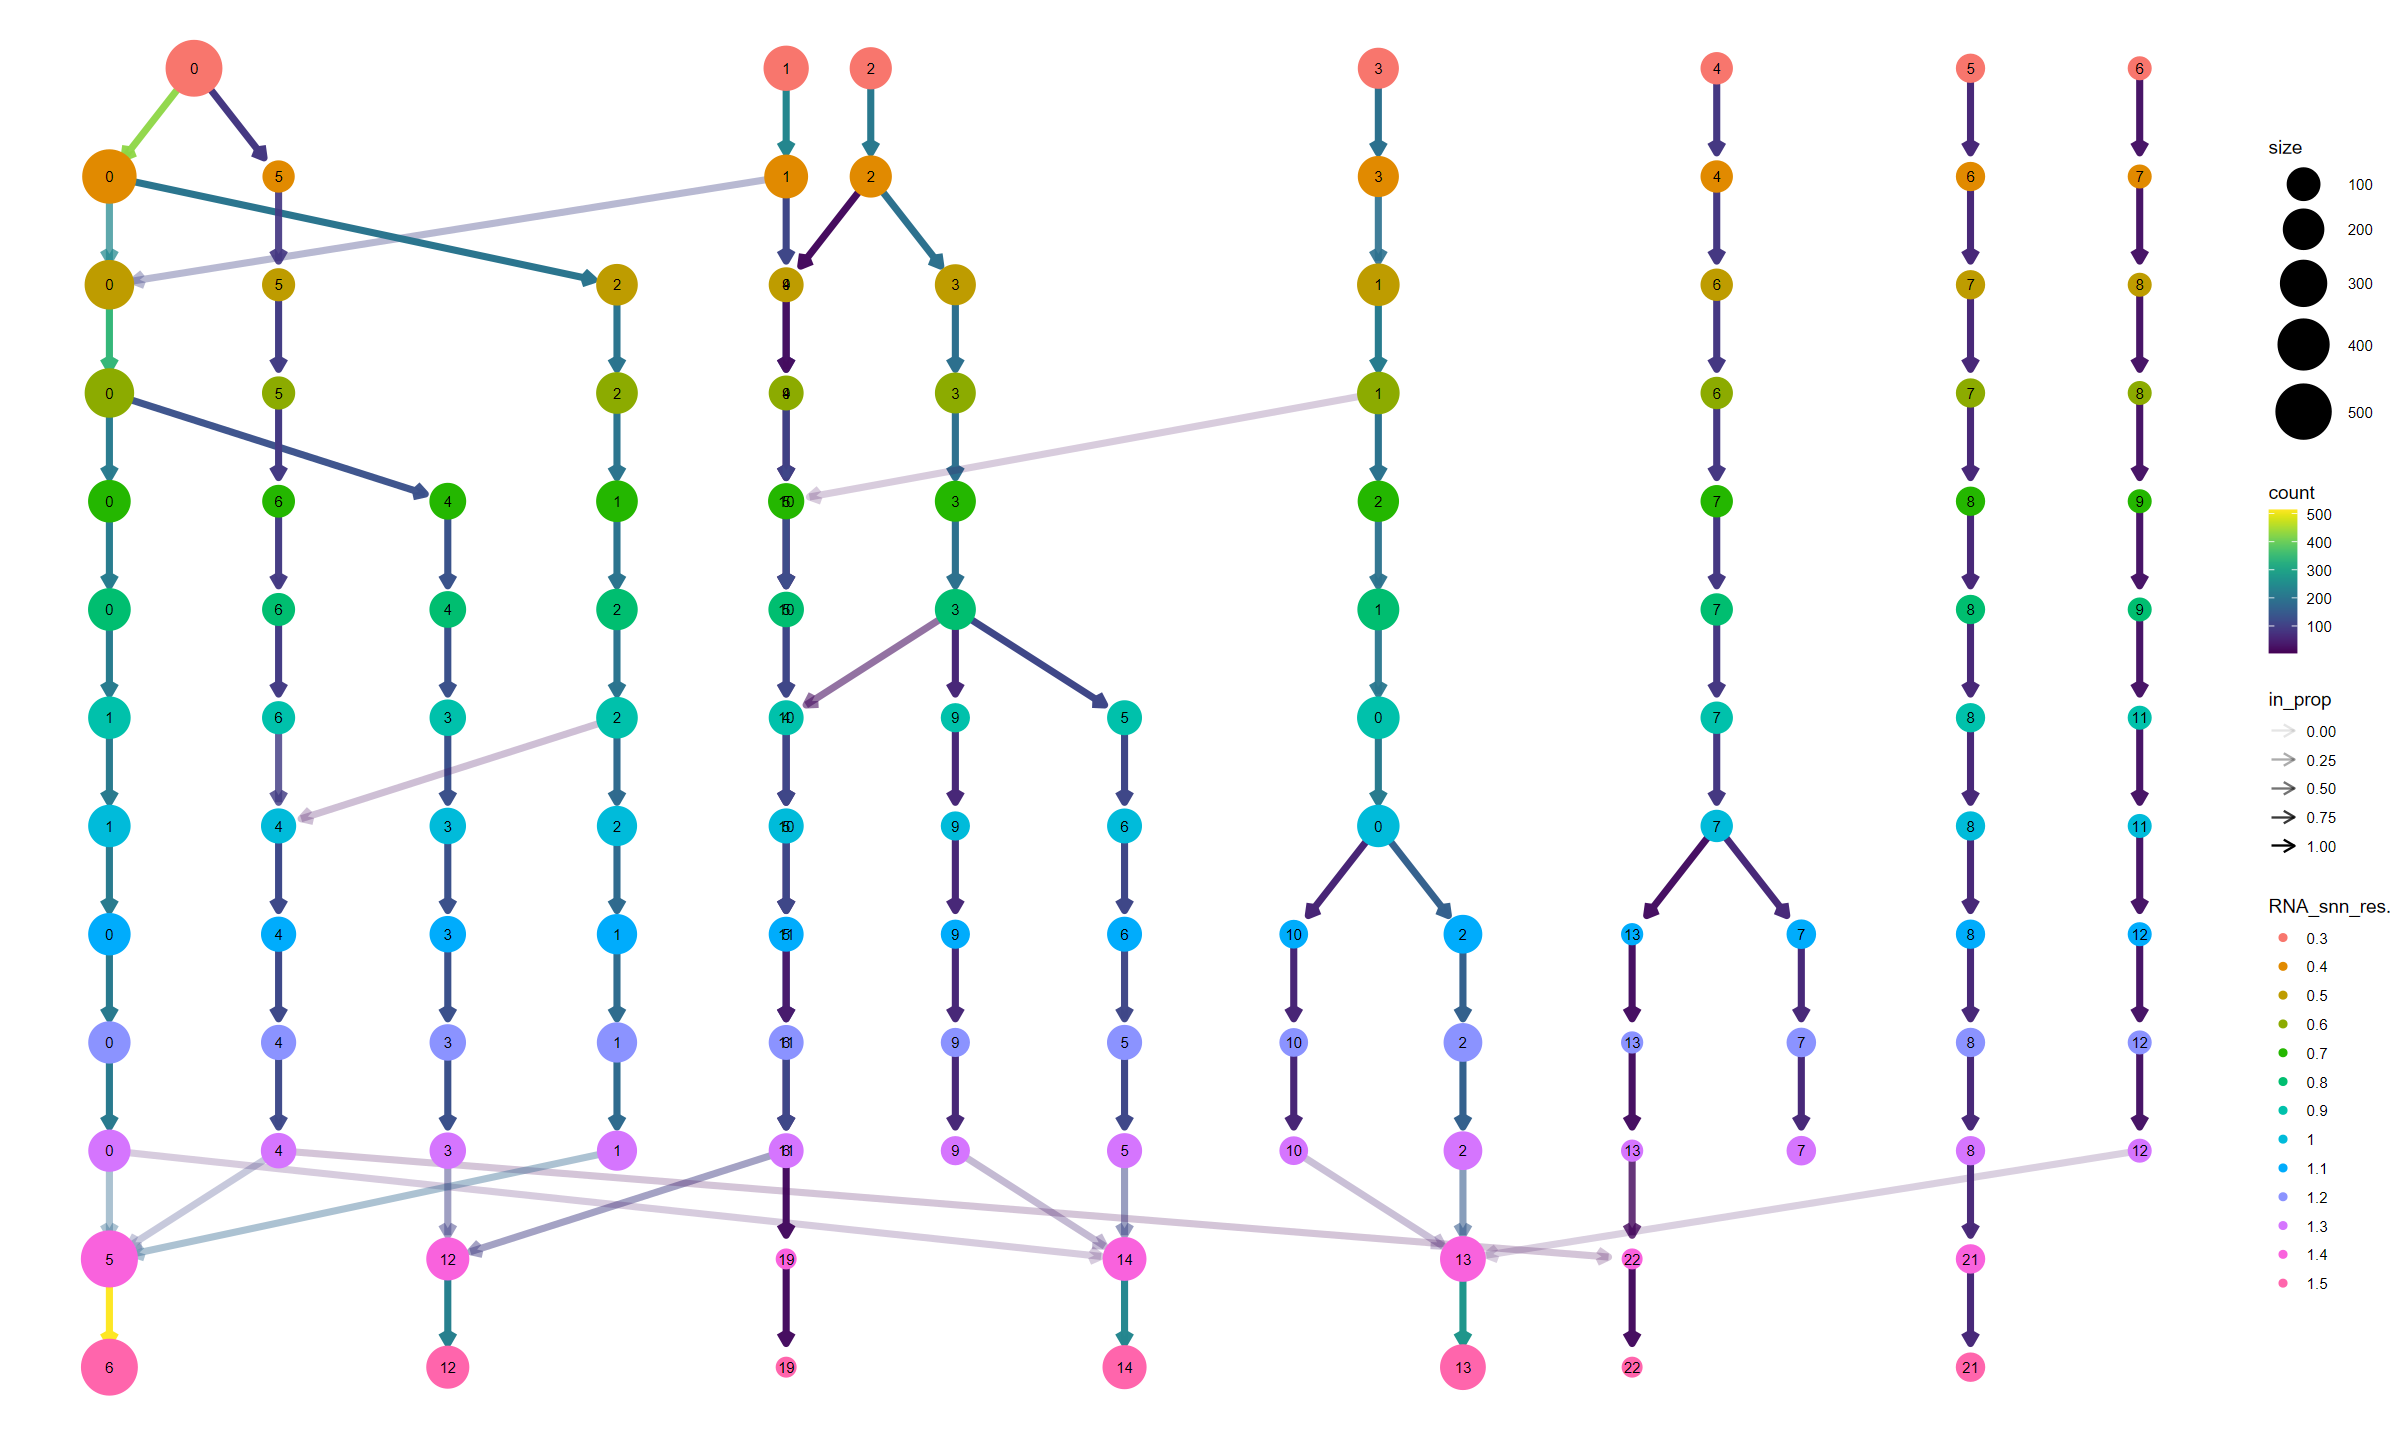

In [43]:
# View the clustree again for the best resolution
clustree(myeloid_data, prefix= "RNA_snn_res.", layout = "sugiyama")

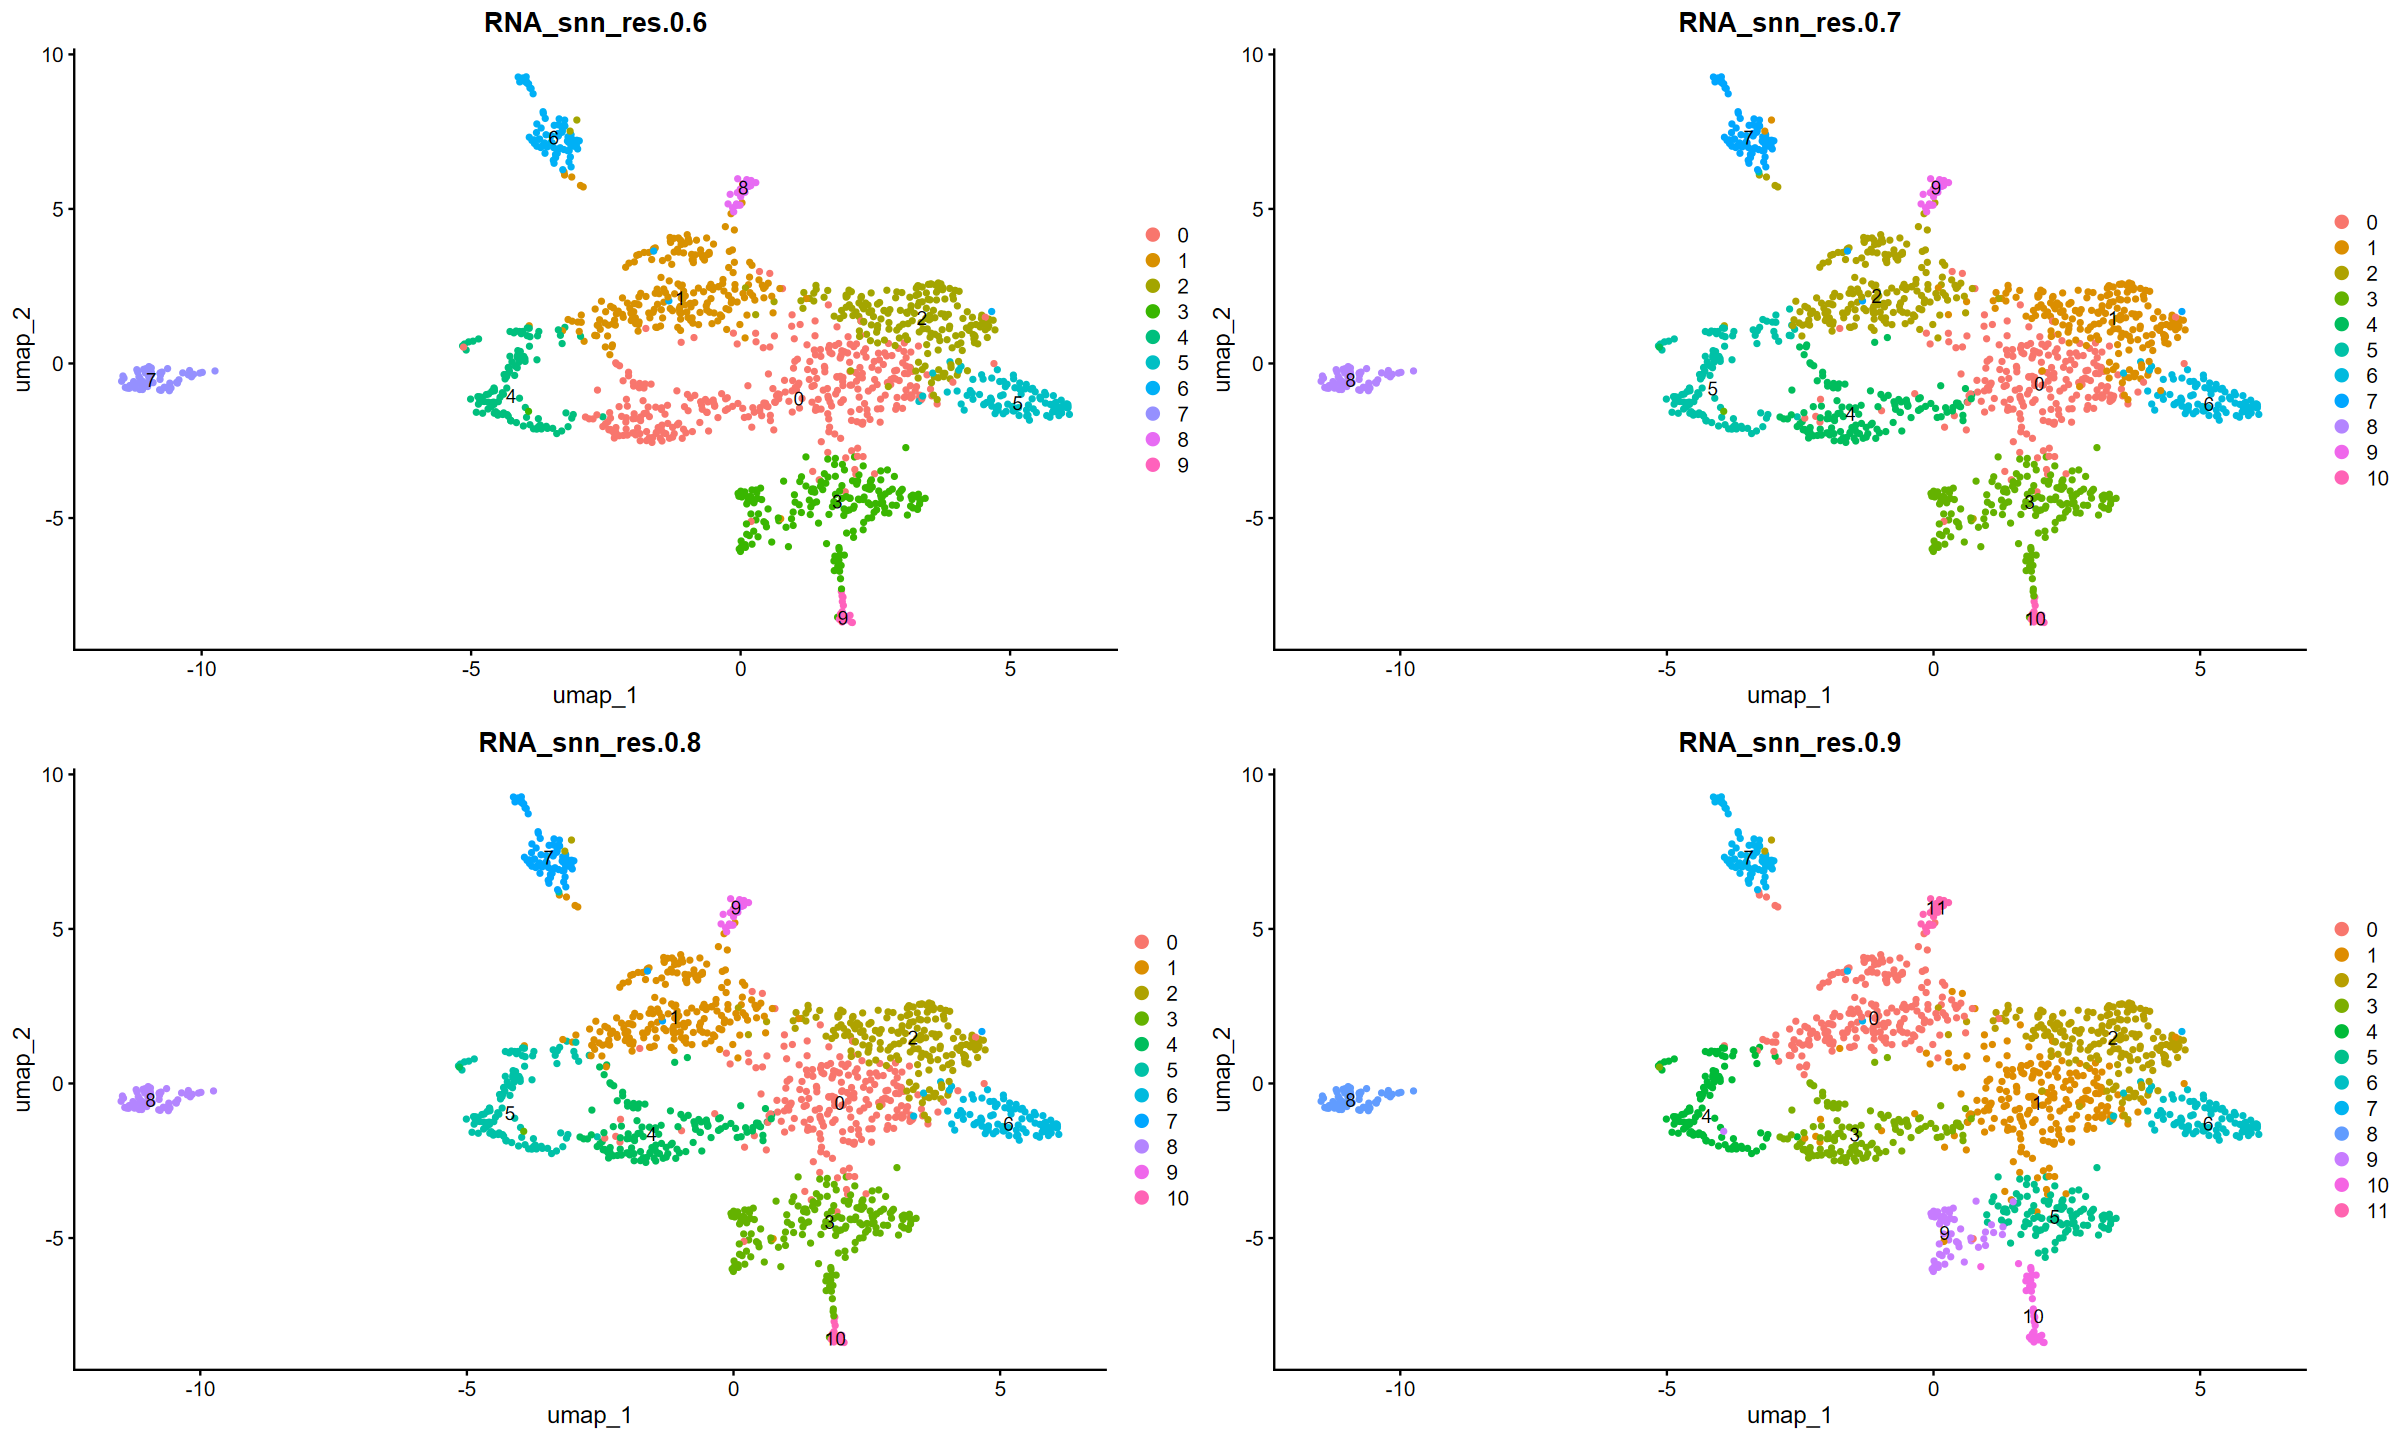

In [46]:
# Get DimPlots of different resolutions
res_1 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.6", label = T)
res_2 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.7", label = T)
res_3 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.8", label = T)
res_4 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.9", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

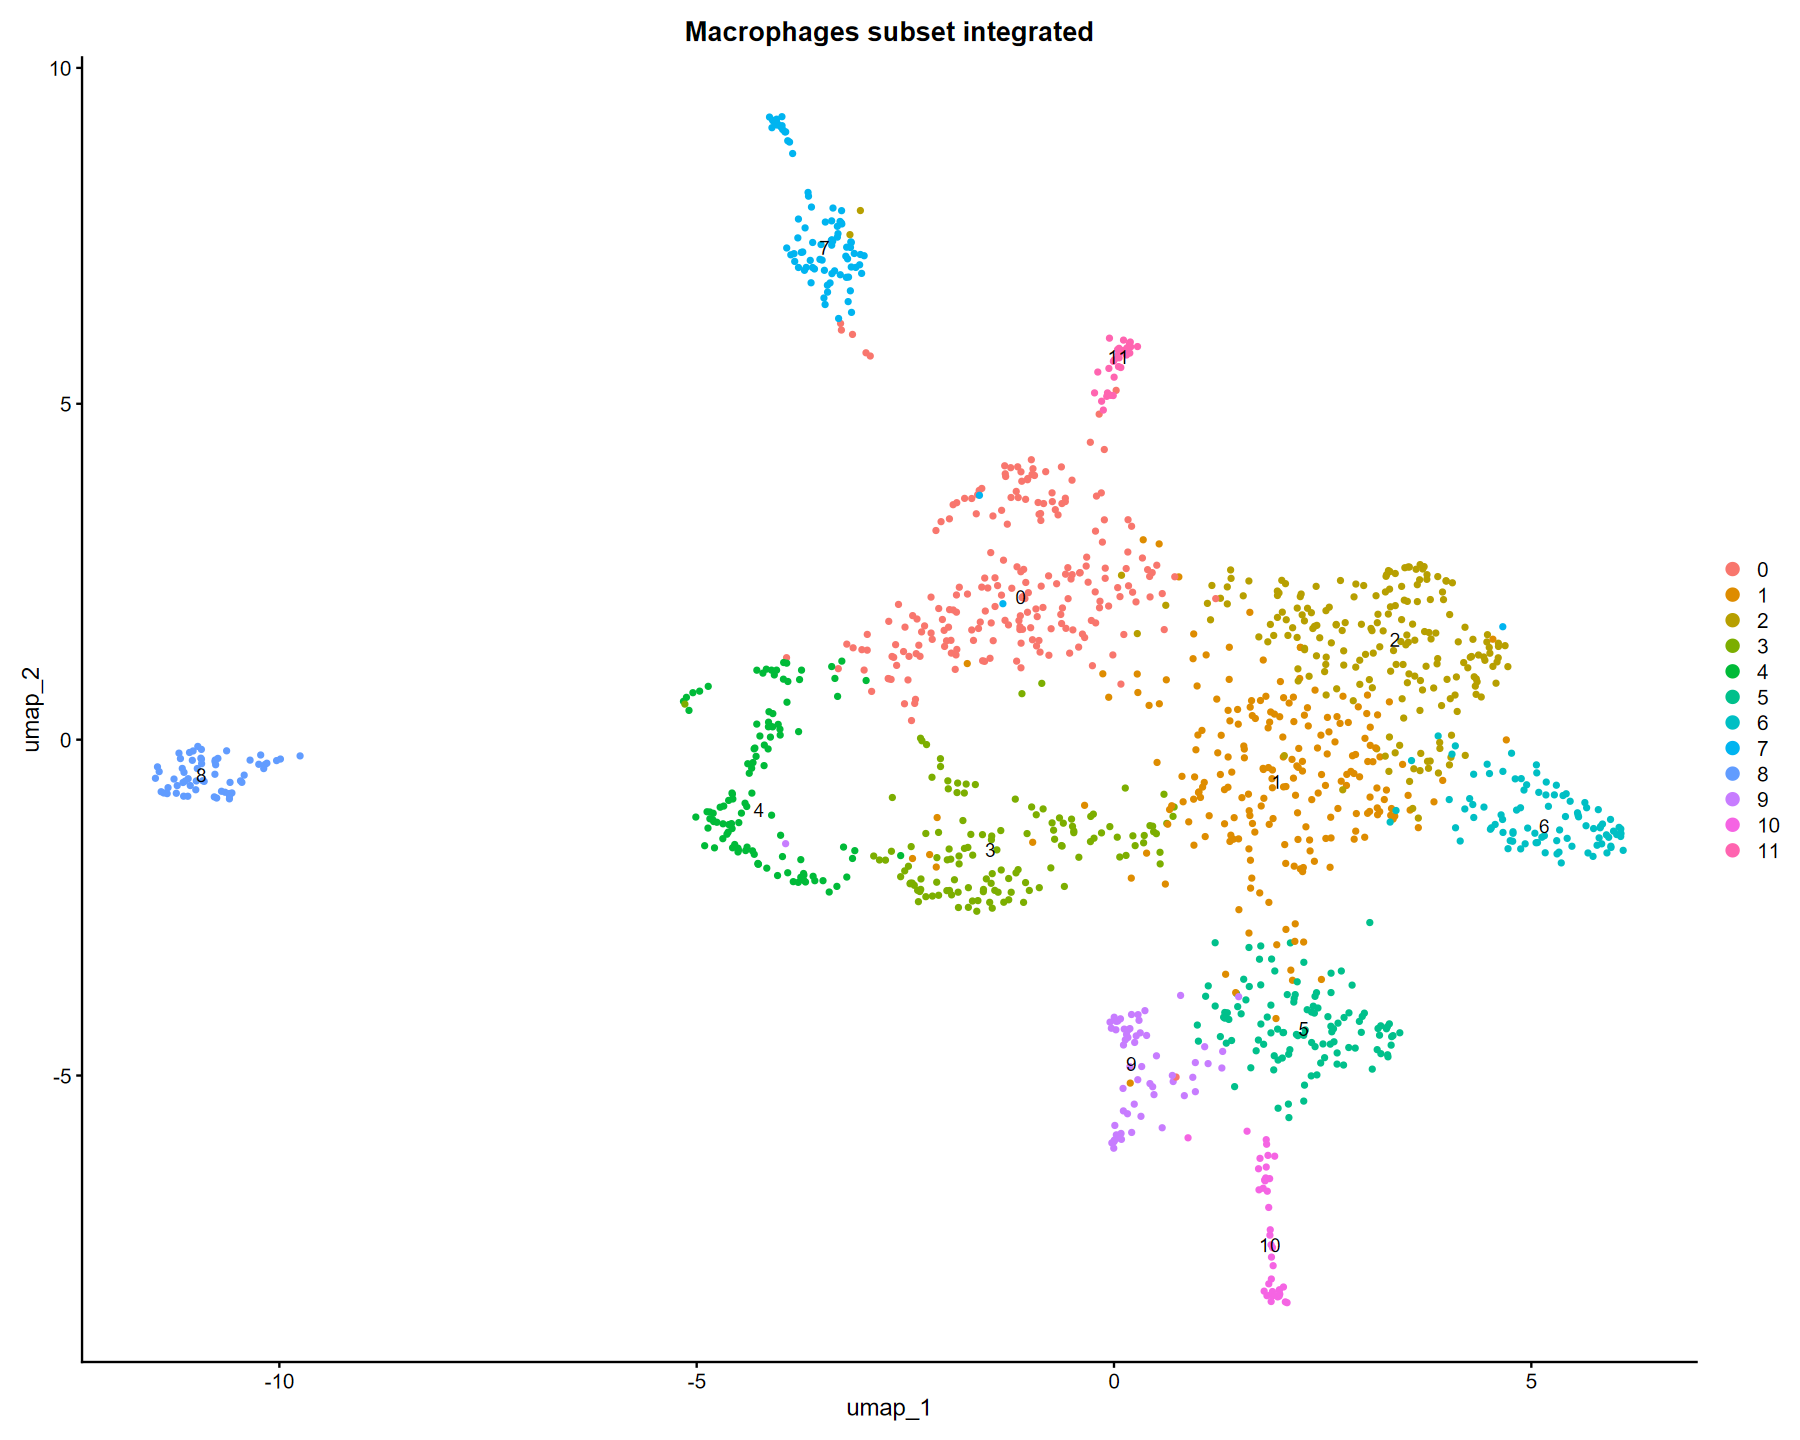

In [58]:
# Assign the slot "Seurat Cluster" to the desired resolution
myeloid_data$seurat_clusters <- myeloid_data$`RNA_snn_res.0.9`
Idents(myeloid_data) <- "seurat_clusters"

# Plot
DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.9", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

In [65]:
ncol(myeloid_data)

[1] 1353

In [63]:
# Save the data
saveRDS(myeloid_data, "Menno_myeloid_data.rds")